In [1]:
from __future__ import absolute_import, print_function, division
from builtins import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
import os
import hypothesis
import hypothesis.extra.numpy as exnp
import h5py
%matplotlib inline

In [2]:
datapath = '/home/mhazoglou/Downloads/greenball/'
dirlist = os.listdir(datapath)

In [3]:
def flatten_image(img_arr, input_shape):
    """
    input_shape in the shape of the input going to a single PVM_unit
    in the horizontal and vertical direction
    img_arr to flatten in so that we get input_shape sized rectangles
    going to PVM units in the first layer
    """
    # don't be dumb and change the data type
    datatype = img_arr.dtype
    L_y, L_x, n_color = img_arr.shape
    l_x, l_y = input_shape
    block_size = l_x*l_y*n_color
    
    x_div = L_x/l_x
    y_div = L_y/l_y
    
    # initialize flat array without changing the data type
    flat_arr = np.zeros(L_x*L_y*n_color, dtype=datatype)
    assert x_div % 1 == 0
    assert y_div % 1 == 0
    
    x_div = int(x_div)
    y_div = int(y_div)
    
    for x in range(x_div):
        for y in range(y_div):
            flat_arr[block_size*(x+y*x_div):block_size*(x+y*x_div+1)] = \
            img_arr[y*l_y:(y+1)*l_y, x*l_x:(x+1)*l_x, :].flatten()
    return flat_arr

In [4]:
def unflatten_image(flat_arr, image_shape, input_shape):
    # don't be dumb and change the data type 
    datatype = flat_arr.dtype
    L_y, L_x, n_color = image_shape
    l_x, l_y = input_shape
    block_size = l_x*l_y*n_color
    
    x_div = L_x/l_x
    y_div = L_y/l_y
    
    # initialize flat array with changing the data type
    img_arr = np.zeros((L_y, L_x, n_color), dtype=datatype)
    assert x_div % 1 == 0
    assert y_div % 1 == 0
    
    x_div = int(x_div)
    y_div = int(y_div)
    
    for x in range(x_div):
        for y in range(y_div):
            img_arr[y*l_y:(y+1)*l_y, x*l_x:(x+1)*l_x, :] = \
            flat_arr[block_size*(x+y*x_div):block_size*(x+y*x_div+1)].reshape((l_y, l_x, n_color))
    return img_arr

In [5]:
ints = hypothesis.strategies.integers
@hypothesis.given(exnp.arrays(np.uint8, (10, 30, 3), elements=ints(0, 32)))
def test_flatten_inverts(img):
    assert (unflatten_image(flatten_image(img, (6, 5)), img.shape, (6, 5)) == img).all()

test_flatten_inverts()

In [18]:
new_size = 96
input_shape = (6, 6)

datadict = {}
groundtruthdict = {}
for dir_ in dirlist:
    
    df = pd.read_csv(datapath + dir_+ '/groundtruth_rect.0.txt', header=None)
    
    imgpath = datapath + '/'.join([dir_, 'img/'])
    imglist = sorted(os.listdir(imgpath))
    flat_img_list = []
    pos_width_list = []
    for idx, img in enumerate(imglist):
        img_open = Image.open(datapath+'/'.join([dir_, 'img/', img]))
        l_x, l_y = img_open.size
        x, x_w = (new_size/l_x)*df[[0, 2]].iloc[idx]
        y, y_w = (new_size/l_y)*df[[1, 3]].iloc[idx]
        img_resize = img_open.resize((new_size, new_size), Image.ANTIALIAS)
#         img_resize = img_resize.filter(ImageFilter.BLUR)
#         img_resize = img_resize.filter(ImageFilter.BLUR)
        img_arr = np.array(img_resize)
        flat_img = flatten_image(img_arr, input_shape)
        flat_img_list.append(flat_img)
        pos_width_list.append([x, y, x_w, y_w])
    # each row of the array is an image and since it is 
    # sorted I should have an easy time with the training
    groundtruthdf = pd.DataFrame(pos_width_list, columns=['x', 'y', 'x_w', 'y_w'])
    datadict[dir_] = np.array(flat_img_list)
    groundtruthdict[dir_] = groundtruthdf

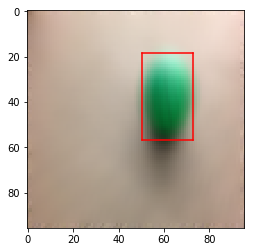

In [19]:
plt.imshow(unflatten_image(flat_img, (new_size, new_size, 3), input_shape))
x, x_w = (new_size/l_x)*df[[0, 2]].iloc[idx]
y, y_w = (new_size/l_y)*df[[1, 3]].iloc[idx]
plt.plot([x, x+x_w], [y, y], 'r')
plt.plot([x, x], [y, y+y_w], 'r')
plt.plot([x+x_w, x], [y+y_w, y+y_w], 'r')
plt.plot([x+x_w, x+x_w], [y, y+y_w], 'r')
plt.show()

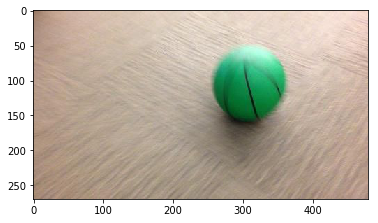

In [20]:
plt.imshow(img_open)
plt.show()

In [25]:
img_open.size

(480, 270)

In [33]:
img_arr = np.array(img_open)

In [51]:
flatten_image(img_arr, (20, 30))

array([141, 110,  90, ..., 173, 143, 132], dtype=uint8)

In [53]:
(unflatten_image(flatten_image(img_arr, (20, 30)), img_arr.shape, (20, 30)) == img_arr).all()

True

In [21]:
outpath = '/media/sdb/'
root = outpath + 'green_ball/'
if root.rsplit('/')[-2] not in os.listdir(outpath):
    os.mkdir(root)

for key, array in datadict.items():
    filename = root + key
    np.save(filename, array)
    groundtruthdict[key].to_csv(filename + '.csv', index = False)

In [ ]:
greenball_long_data = np.load(root + dirlist[0]+'.npy')

In [ ]:
greenball_long_data

In [14]:
import pandas as pd

datapath = '/home/mhazoglou/Downloads/greenball/'
dirlist = os.listdir(datapath)


df = pd.read_csv(datapath + dirlist[0] + '/groundtruth_rect.0.txt', header=None)

In [21]:
df#.loc[:,1:]

0   1    2    3
0    171  92  142  142
1    172  88  139  139
2    173  84  136  136
3    174  80  134  134
4    175  76  131  131
5    176  72  128  128
6    177  68  126  126
7    178  64  123  123
8    179  61  121  121
9    178  54  120  120
10   176  48  119  119
11   175  41  119  119
12   173  35  118  118
13   172  28  118  118
14   170  22  117  117
15   169  16  117  117
16   171  21  116  116
17   174  26  115  115
18   176  31  114  114
19   179  37  113  113
20   181  42  112  112
21   184  47  111  111
22   186  52  110  110
23   189  58  109  109
24   189  61  108  108
25   189  64  108  108
26   189  67  107  107
27   189  70  107  107
28   190  73  106  106
29   190  76  106  106
..   ...  ..  ...  ...
880  296  54  133  133
881  292  54  133  133
882  288  55  133  133
883  283  55  133  133
884  279  55  133  133
885  274  55  133  133
886  270  56  133  133
887  266  56  133  133
888  261  56  133  133
889  257  56  133  133
890  252  57  133  133
891  248  57  133  133
892  244  57  133  133
893  240  57  133  133
894  237  57  133  133
895  234  56  133  133
896  230  56  133  133
897  227  56  133  133
898  224  56  133  133
899  220  56  133  133
900  217  55  133  133
901  214  55  133  133
902  210  55  133  133
903  207  55  133  133
904  204  55  133  133
905  200  54  133  133
906  197  54  133  133
907  194  54  133  133
908  190  54  133  133
909  186  53  133  133

[910 rows x 4 columns]

In [1]:
from FormattingFiles import reformat_tracker_data, save_tracker_data_to

In [7]:
datapath = '/home/mhazoglou/Downloads/PVM_set/'
new_size = (96, 96)
input_shape = (3, 3)
save_dir = '/media/sdb/PVM_full_set_input_shape_3_by_3/'

datadict, groundtruthdict = reformat_tracker_data(datapath, new_size, input_shape)

In [3]:
save_tracker_data_to(save_dir, datadict, groundtruthdict)

In [15]:
(datadict['blue_ball_at_home_01']-np.load(save_dir + 'blue_ball_at_home_01.npy'))

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [2]:
from FormattingFiles import save_tracker_data_to, reformat_raw_data

In [ ]:
datapath = '/home/mhazoglou/Downloads/PVM_set/'
new_size = (96, 96)
save_dir = '/media/sdb/PVM_full_set_raw/'

datadict, groundtruthdict = reformat_raw_data(datapath, new_size)

In [ ]:
datadict['blue_ball_at_home_01'][0, ...].shape

In [11]:
save_tracker_data_to(save_dir, datadict, groundtruthdict)

In [9]:
for n in range(1, 12):
    path = '/media/sdb/720p_image_data/Teo_car_{}/'.format(n)
    f = os.listdir(path + 'img')

    with open(path + 'groundtruth_rect.0.txt', 'w') as fid:
        for fname in f:
            fid.write(u'-1, -1, -1, -1\n')
        
    

In [5]:
def hdf5_raw_data(datapath, filename, new_size, img_dir='img'):
    """
    Reads data in the with the directory structure:
    datapath
        |
        |---name_of_dataset_directory1
        |       |---img_dir
        |       |       |---img0001
        |       |       |---img0002
        |       |       |---img0003
        |       |       |---img0004
        |       |       .
        |       |       .
        |       |       .
        |       |
        |       |
        |
        |---name_of_dataset_directory2
        |       |---img_dir
        |       |       |---img0001
        |       |       |---img0002
        |       |       |---img0003
        |       |       |---img0004
        |       |       .
        |       |       .
        |       |       .
        |       |
        |       |
        .
        .
        .

    in each folder with the image data needs to be ordered in time with the
    earliest at the top and latest at the bottom

    :param datapath: A string with the name of a directory containing the
    data.
    :param filename: A string containing the path and filename of the hdf5 file
    that is being written the .hdf5 extension is not needed
    :param new_size: A tuple with new sizes of the vertical and horizontal
    dimensions of the image.
    :param img_dir: It defaults to 'img', a string with the common name of the
    directory. 
    :param n_color: The number of colors used in the format of the image it
    defaults to 3 for RGB
    """
    dirlist = os.listdir(datapath)
    new_size_y, new_size_x = new_size
    
#     rectlin = lambda z: z if z > 0 else 0
    with h5py.File(filename, 'w') as f:
        for dir_ in dirlist:

            imgpath = datapath + '/'.join([dir_, img_dir + '/'])
            imglist = sorted(os.listdir(imgpath))
            img_list = []
#             pos_width_list = []
            for idx, img in enumerate(imglist):
                img_open = Image.open(datapath + '/'.join([dir_, img_dir, img]))
#                 L_x, L_y = img_open.size
                img_resize = img_open.resize((new_size_x, new_size_y),  # (width, height)
                                             Image.ANTIALIAS)
                img_arr = np.array(img_resize)
                img_list.append(img_arr)
            # each row of the array is an image and since it is
            # sorted I should have an easy time with the training
            f[dir_] = np.array(img_list)

In [2]:
def hdf5_append_position_data(datapath, filename, new_size, img_dir='img'):
    """
    Reads data in the with the directory structure:
    datapath
        |
        |---name_of_dataset_directory1
        |       |---output.txt
        |       |---img_dir
        |       |       |---img0001
        |       |       |---img0002
        |       |       |---img0003
        |       |       |---img0004
        |       |       .
        |       |       .
        |       |       .
        |       |
        |       |
        |
        |---name_of_dataset_directory2
        |       |---output.txt
        |       |---img_dir
        |       |       |---img0001
        |       |       |---img0002
        |       |       |---img0003
        |       |       |---img0004
        |       |       .
        |       |       .
        |       |       .
        |       |
        |       |
        .
        .
        .

    in each folder with the image data needs to be ordered in time with the
    earliest at the top and latest at the bottom

    :param datapath: A string with the name of a directory containing the
    data.
    :param filename: A string containing the path and filename of the hdf5 file
    that is being written the .hdf5 extension is not needed
    :param new_size: A tuple with new sizes of the vertical and horizontal
    dimensions of the image.
    :param img_dir: It defaults to 'img', a string with the common name of the
    directory. 
    :param n_color: The number of colors used in the format of the image it
    defaults to 3 for RGB
    """
    dirlist = os.listdir(datapath)
    new_size_y, new_size_x = new_size
    
    with h5py.File(filename, 'w') as f:
        for dir_ in dirlist:
            df = pd.read_csv(datapath + '/'.join([dir_, 'output.txt']), header=None,
                             names=['time', 'pan', 'tilt']
                            )
            df['time'] = pd.to_datetime(df['time'])
            
            df['pan'] = df['pan'] / 1023.
            df['tilt'] = df['tilt'] / 1023.
            df['dt'] = df['time'].diff()
            df['dpan'] = (df['pan'].diff() + 1.) / 2.
            df['dtilt'] = (df['tilt'].diff() + 1.) / 2.

#             df = df.drop(0)
            
            imgpath = datapath + '/'.join([dir_, img_dir + '/'])
            imglist = sorted(os.listdir(imgpath))
            img_list = []
            name_list = []
            for img in imglist[1:]:
                time = img.split('.png')[0]
                img_open = Image.open(datapath + '/'.join([dir_, img_dir, img]))
                img_resize = img_open.resize((new_size_x, new_size_y),  # (width, height)
                                             Image.ANTIALIAS)
                img_arr = np.array(img_resize)
                img_list.append(img_arr)
                name_list.append(time)
            
#             df['frame time'] = pd.to_datetime(
#                 pd.Series(name_list, index=range(1, len(name_list)+1))
#             )
            
            df['dpan/dt (1/ms)'] = df['dpan'] * np.timedelta64(1, 'ms') / df['dt']
            df['dtilt/dt (1/ms)'] = df['dtilt'] * np.timedelta64(1, 'ms') / df['dt']

#             df['interpolated_pan']  = (
#                 df['dpan/dt (1/ms)'] * (df['frame time'] - 
#                                  df['time']) / np.timedelta64(1, 'ms') + 
#                 df['pan']
#             )
#             df['interpolated_tilt'] = (
#                 df['dtilt/dt (1/ms)'] * (df['frame time'] - 
#                                   df['time']) / np.timedelta64(1, 'ms') + 
#                 df['tilt']
#             )
                
            # each row of the array is an image and since it is
            # sorted I should have an easy time with the training
            grp = f.create_group(dir_)
            grp.create_dataset('images', data=np.array(img_list))
            grp.create_dataset('position', data=df[['pan', 
                                                    'tilt',
                                                    'dpan',
                                                    'dtilt']])

In [8]:
datapath = '/media/sdb/MotionAndVisionIntegrationData/'
#'/media/sdb/MotionAndVisionIntegrationData/'#'/media/sdb/PVM_test_set/'#'/media/sdb/720p_test_data/'#'/media/sdb/People_walking/'#
new_size = (96, 128)#(240, 320)#(99, 176)#(198, 352)#(96, 96)#
filename = '/media/sdb/PVM_movement_integration_train_set_96h_by_128w.hdf5'
#'/media/sdb/PVM_movement_integration_train_set_96h_by_128w_no_position.hdf5'


#'/media/sdb/PVM_train_set_96h_by_128w.hdf5'
#'/media/sdb/PVM_train_set_96h_by_128w.hdf5'
#'/media/sdb/720p_People_walking_rescaled_to_99_by_176_formatted_testing.hdf5'
#'/media/sdb/720p_rescaled_to_198_by_352_formatted_testing.hdf5'
#'/media/sdb/PVM_test_set.hdf5'#'/media/sdb/720p_rescaled_to_99_by_176_formatted_testing.hdf5'

# hdf5_raw_data(datapath, filename, new_size, img_dir='img')
hdf5_append_position_data(datapath, filename, new_size, img_dir='img')

In [45]:
filename = '/media/sdb/PVM_movement_integration_train_set_96h_by_128w.hdf5'
raw_data = h5py.File(filename, 'r')

In [46]:
for key in raw_data.keys():
    print(key)

2018-12-11T22:32:15.003466
2018-12-11T23:16:37.113812
2018-12-11T23:57:19.224977
2018-12-13T13:26:29.884728


In [47]:
list(raw_data['2018-12-11T22:32:15.003466'].keys())

['images', 'position']

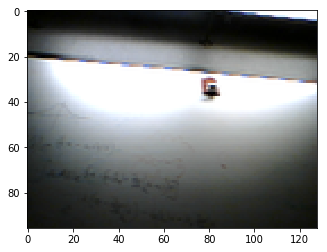

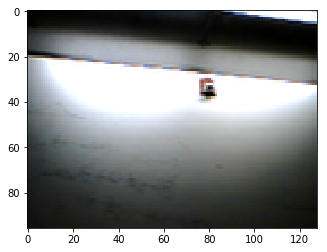

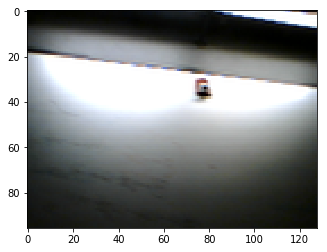

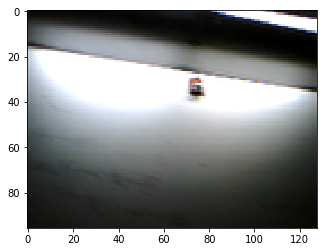

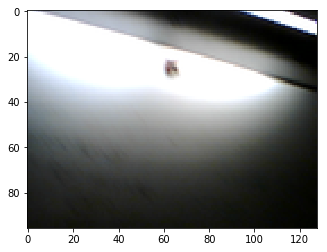

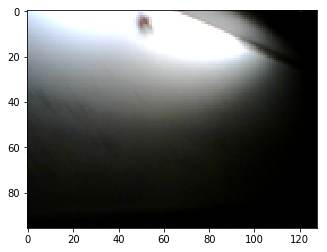

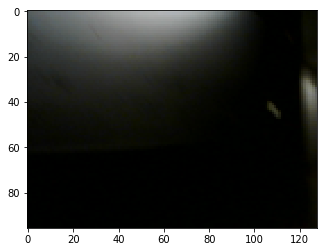

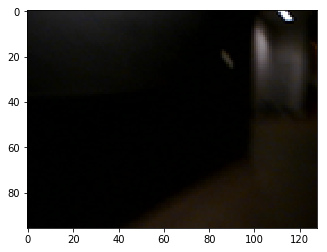

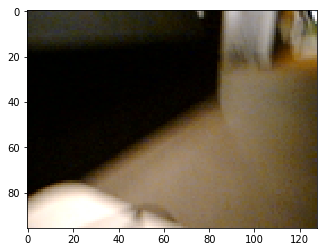

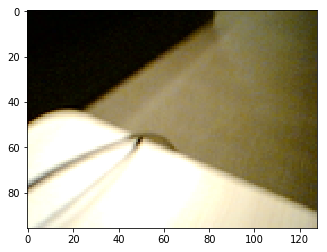

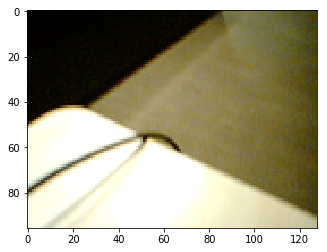

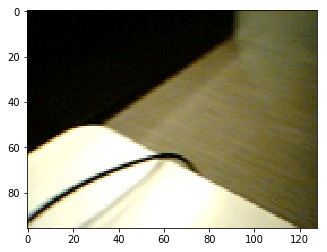

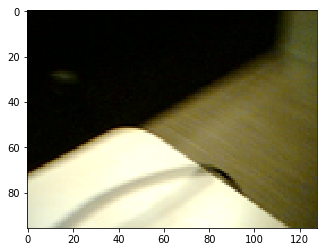

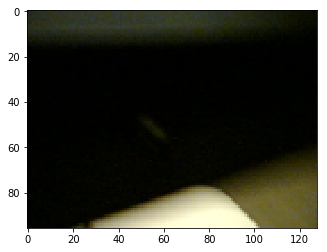

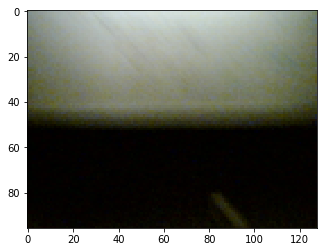

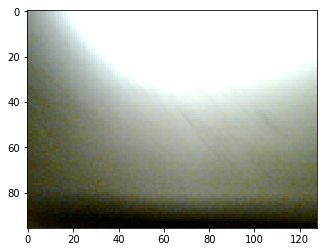

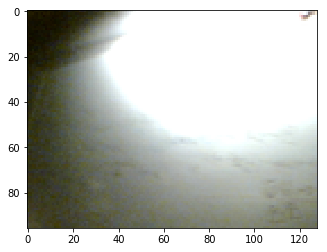

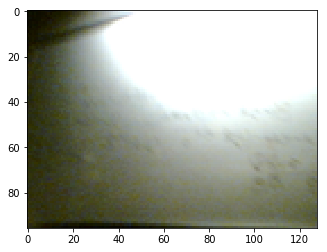

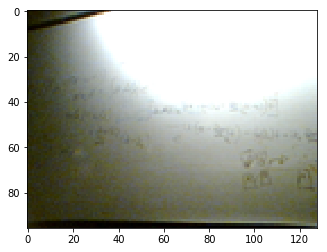

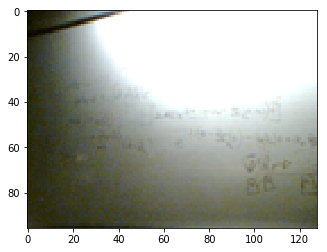

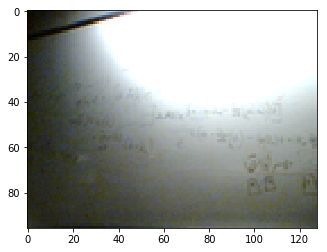

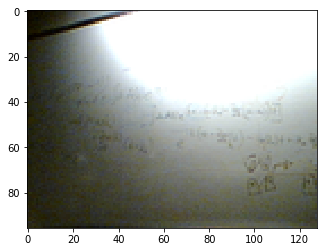

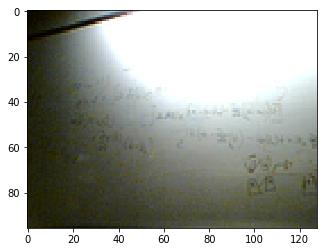

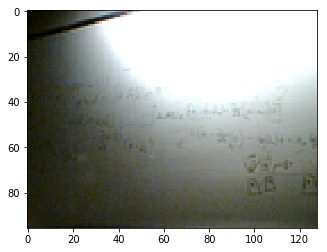

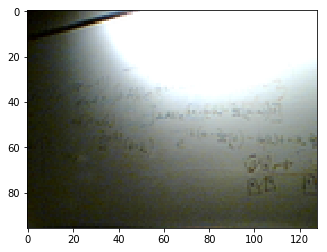

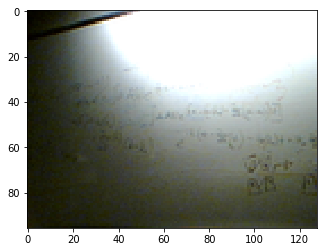

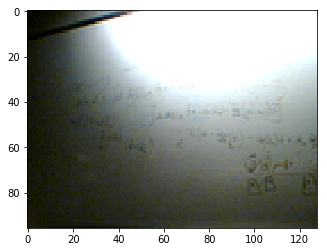

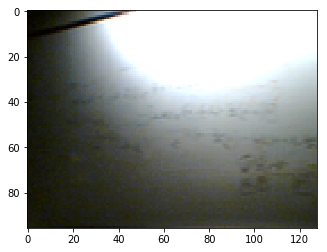

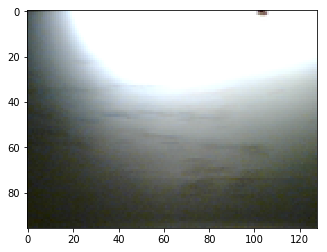

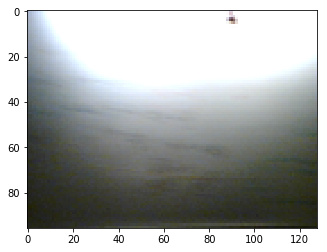

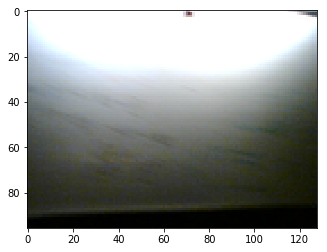

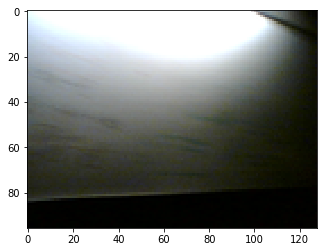

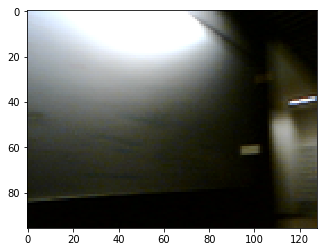

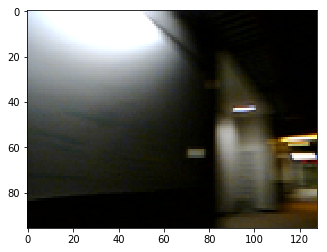

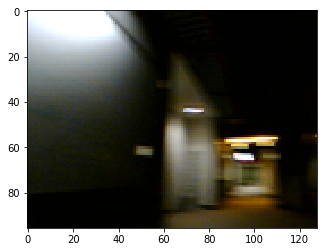

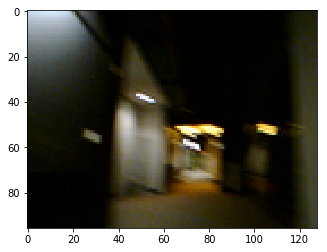

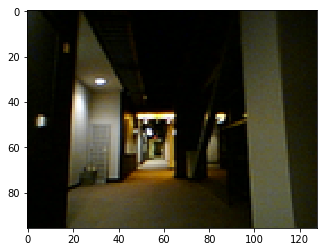

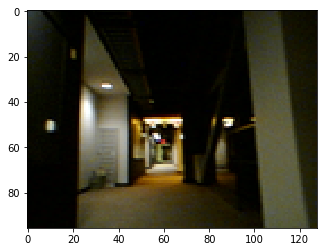

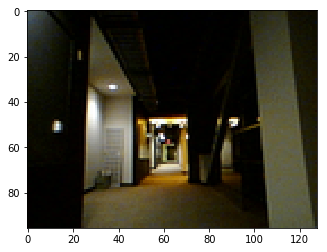

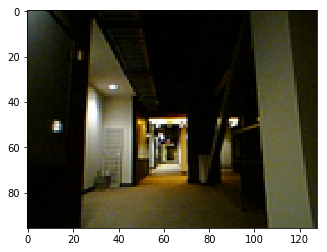

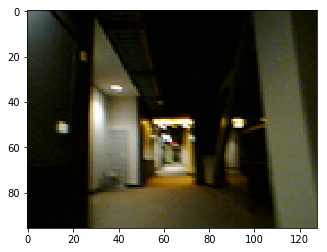

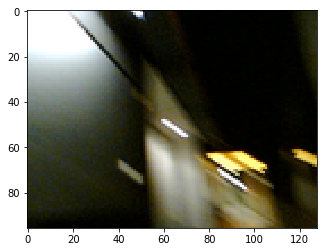

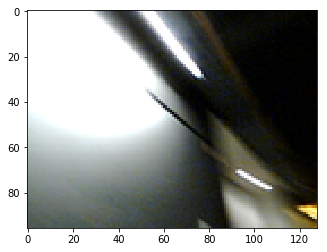

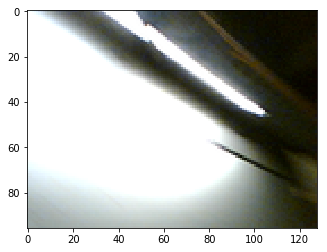

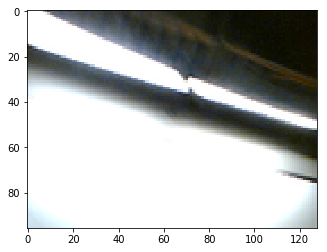

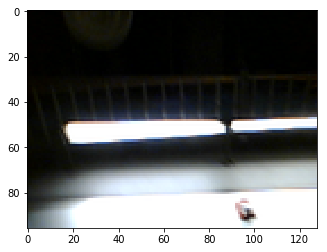

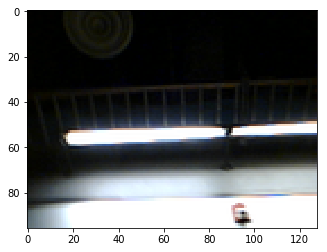

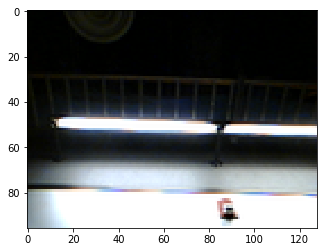

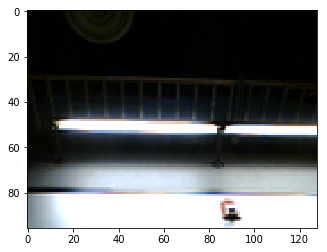

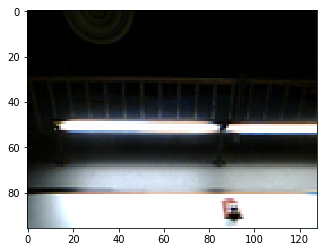

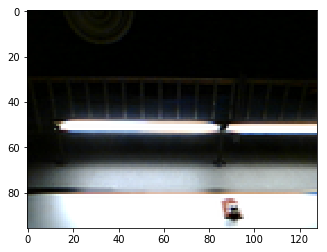

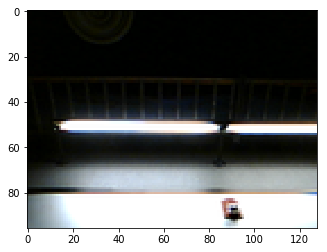

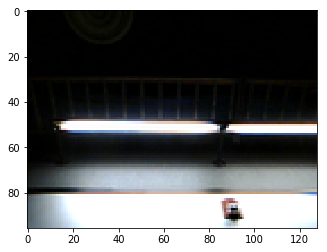

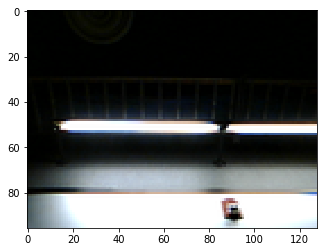

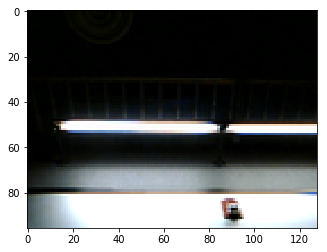

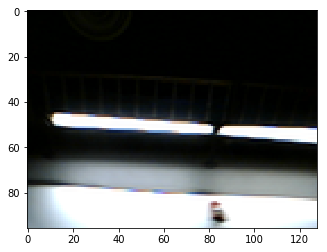

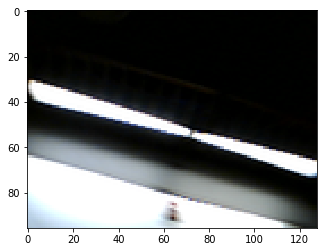

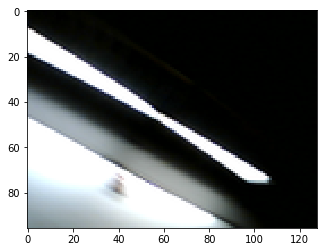

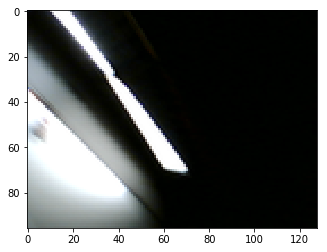

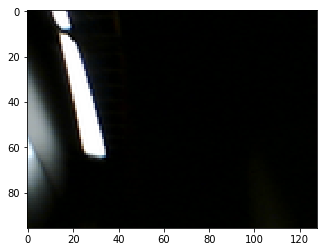

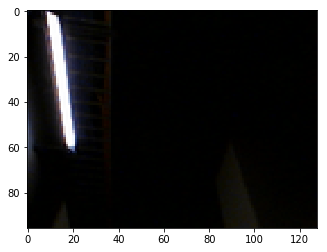

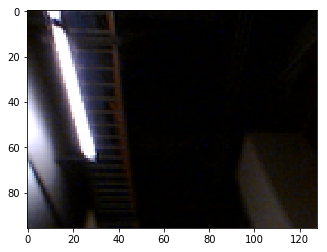

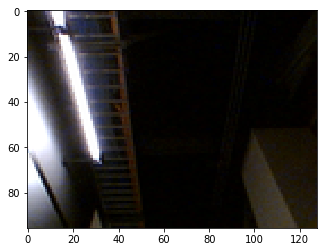

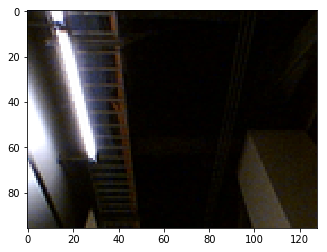

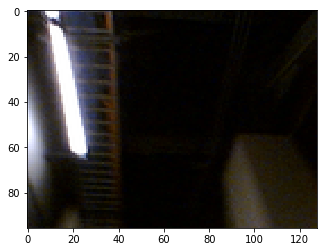

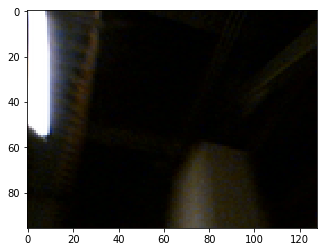

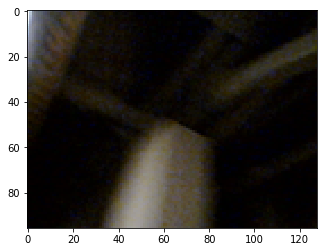

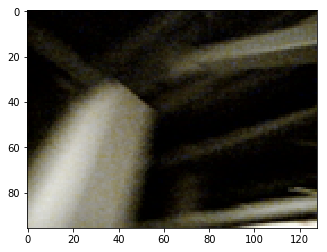

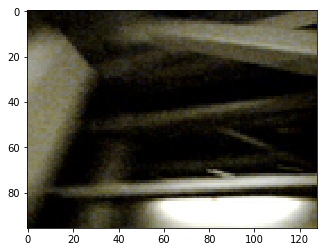

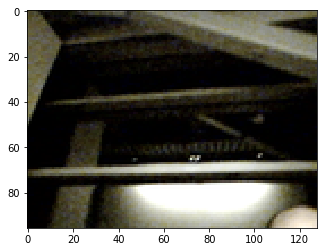

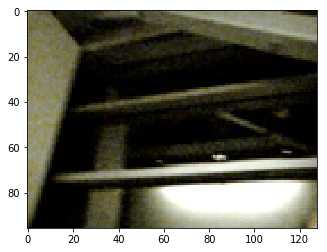

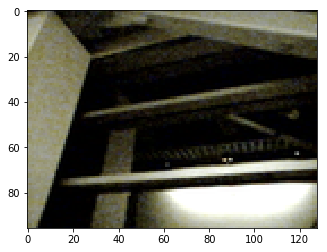

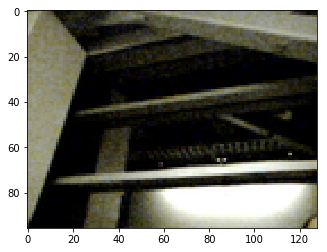

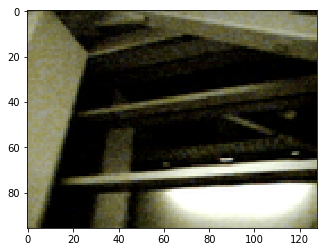

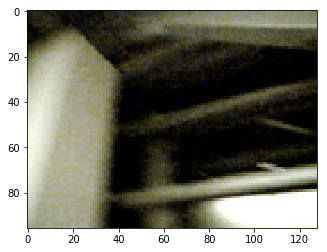

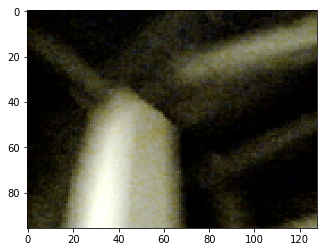

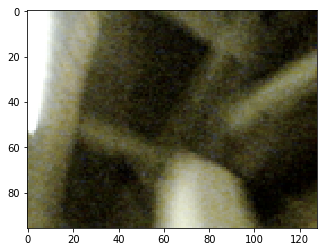

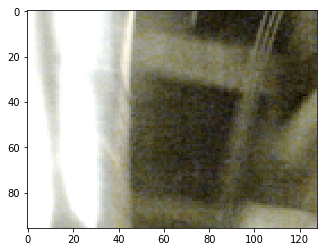

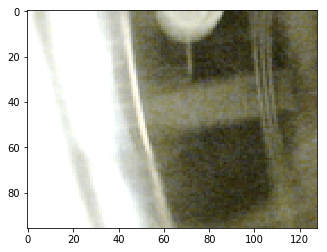

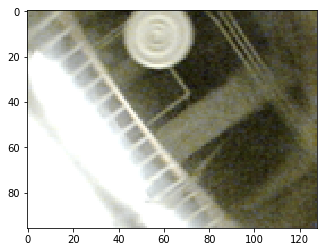

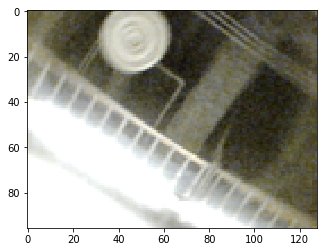

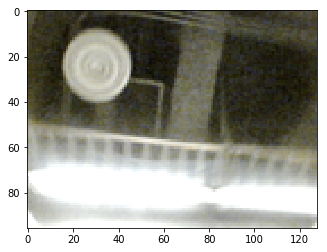

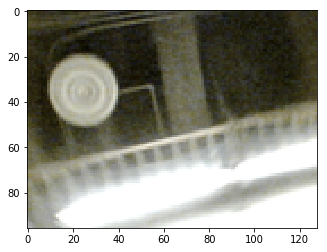

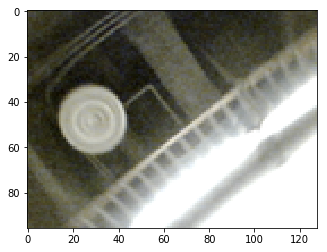

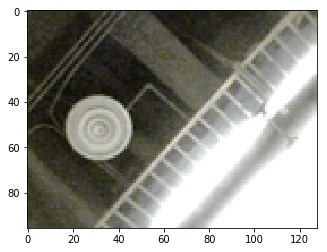

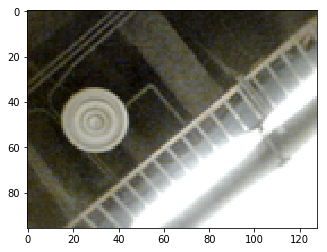

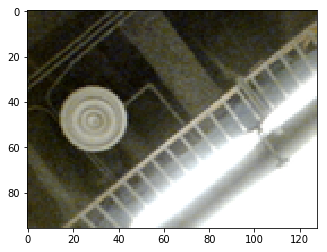

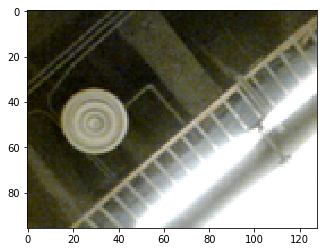

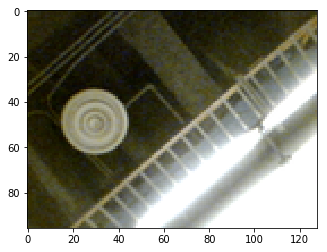

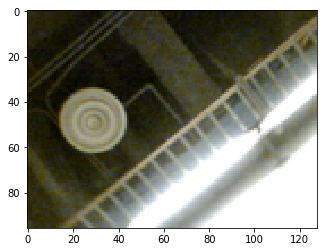

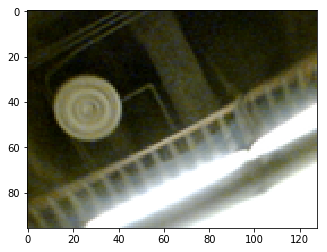

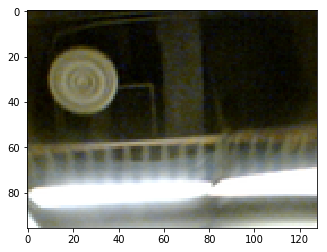

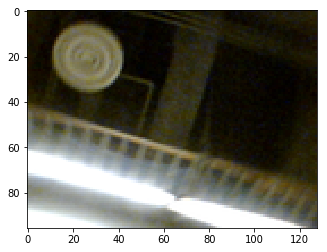

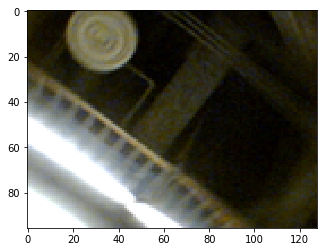

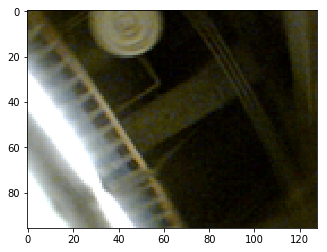

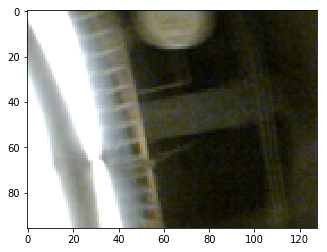

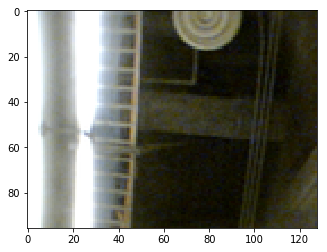

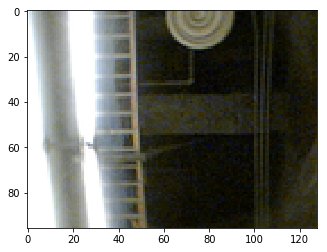

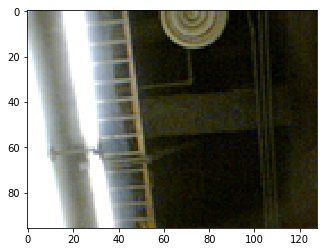

In [41]:
for i in range(1, 100):
    plt.imshow(raw_data['2018-12-11T22:32:15.003466']['images'][i + 1])#.astype(np.float64)) 
#                         - (raw_data['2018-12-11T22:32:15.003466']['images'][i]).astype(np.float64) + 255)/510
              
    plt.show()

In [48]:
raw_data.close()

In [32]:
raw_data['2018-10-25T11:57:52.762466']['position']

<HDF5 dataset "position": shape (1000, 2), type "<i8">

In [60]:
def hdf5_dif(infile, outfile, shift=255):
    with h5py.File(outfile, 'w') as f:
        i = h5py.File(infile, 'r')
        for key, data in i.items():
            der = data[1:, ...].astype(np.int) - data[:-1, ...].astype(np.int) + shift
            f[key] = der

In [61]:
def hdf5_dif_append_position_data(infile, outfile, shift_img=255, shift_pos=1023):
    img = 'images'
    pos = 'position'
    
    with h5py.File(outfile, 'w') as f:
        i = h5py.File(infile, 'r')
        for key, data in i.items():
            der = data[img][1:, ...] - data[img][:-1, ...] + shift_img
            der_pos = data[pos][1:, ...] - data[pos][:-1, ...] + shift_pos
            
            grp = f.create_group(key)
            grp.create_dataset(img, data=der)
            grp.create_dataset(pos, data=der_pos)

In [62]:
infile = '/media/sdb/PVM_movement_integration_train_set_96h_by_128w.hdf5'
outfile = '/media/sdb/dif_PVM_movement_integration_train_set_96h_by_128w.hdf5'
hdf5_dif_append_position_data(infile, outfile)

In [65]:
infile = '/media/sdb/PVM_train_set_96h_by_128w.hdf5'
outfile = '/media/sdb/dif_PVM_train_set_96h_by_128w.hdf5'
hdf5_dif(infile, outfile)

In [66]:
dif_dat = h5py.File(outfile, 'r')

In [67]:
list(dif_dat.keys())

['blue_ball_at_home_01',
 'blue_ball_at_home_02',
 'blue_ball_on_grass_daytime',
 'face01',
 'face02',
 'face03',
 'face04',
 'face05',
 'face06',
 'face07',
 'face08',
 'face09',
 'face10',
 'green_ball_01_small',
 'green_ball_bc_office',
 'green_ball_long',
 'green_ball_on_grass',
 'no_target',
 'no_target_01',
 'stop01',
 'stop02',
 'stop03',
 'stop04',
 'stop05',
 'stop06',
 'stop07',
 'stop08',
 'stop09',
 'stop10',
 'stop11',
 'stop12',
 'stop13',
 'stop14',
 'stop15',
 'stop16',
 'stop17',
 'stop18',
 'stop19',
 'stop20']

In [70]:
dif_dat['blue_ball_at_home_01'][:].max()

510

In [71]:
dif_dat.close()

In [22]:
df = pd.read_csv("/media/sdb/MotionAndVisionIntegrationData/2018-12-11T22:32:15.003466/output.txt", header=None,
                 names=['time 1', 'pan 1', 'tilt 1', 'time 2', 'pan 2', 'tilt 2'])

df['time 1'] = pd.to_datetime(df['time 1'])
df['time 2'] = pd.to_datetime(df['time 2'])

df['dt'] = df['time 2'] - df['time 1']
df['dpan'] = df['pan 2'] - df['pan 1']
df['dtilt'] = df['tilt 2'] - df['tilt 1']

df = df.drop(0)

In [23]:
df

time 1  pan 1  tilt 1                     time 2  \
1    2018-12-11 22:32:17.685493    525     616 2018-12-11 22:32:17.704679   
2    2018-12-11 22:32:17.729405    503     598 2018-12-11 22:32:17.760413   
3    2018-12-11 22:32:17.782214    473     564 2018-12-11 22:32:17.815172   
4    2018-12-11 22:32:17.846272    437     522 2018-12-11 22:32:17.879157   
5    2018-12-11 22:32:17.910251    401     476 2018-12-11 22:32:17.943075   
6    2018-12-11 22:32:17.974226    370     418 2018-12-11 22:32:18.005183   
7    2018-12-11 22:32:18.027187    370     377 2018-12-11 22:32:18.059036   
8    2018-12-11 22:32:18.090103    370     374 2018-12-11 22:32:18.122078   
9    2018-12-11 22:32:18.144088    384     374 2018-12-11 22:32:18.176061   
10   2018-12-11 22:32:18.207991    428     391 2018-12-11 22:32:18.238999   
11   2018-12-11 22:32:18.260970    476     430 2018-12-11 22:32:18.292912   
12   2018-12-11 22:32:18.314942    533     484 2018-12-11 22:32:18.345933   
13   2018-12-11 22:32:18.367885    593     539 2018-12-11 22:32:18.397908   
14   2018-12-11 22:32:18.421847    632     568 2018-12-11 22:32:18.452766   
15   2018-12-11 22:32:18.484031    633     568 2018-12-11 22:32:18.514833   
16   2018-12-11 22:32:18.537760    633     568 2018-12-11 22:32:18.568666   
17   2018-12-11 22:32:18.589769    633     568 2018-12-11 22:32:18.621658   
18   2018-12-11 22:32:18.651804    633     568 2018-12-11 22:32:18.672826   
19   2018-12-11 22:32:18.695770    633     568 2018-12-11 22:32:18.726653   
20   2018-12-11 22:32:18.747544    633     568 2018-12-11 22:32:18.769510   
21   2018-12-11 22:32:18.789533    633     568 2018-12-11 22:32:18.811481   
22   2018-12-11 22:32:18.832528    633     568 2018-12-11 22:32:18.852572   
23   2018-12-11 22:32:18.875587    633     568 2018-12-11 22:32:18.906615   
24   2018-12-11 22:32:18.929512    633     568 2018-12-11 22:32:18.959590   
25   2018-12-11 22:32:18.981400    627     568 2018-12-11 22:32:19.014346   
26   2018-12-11 22:32:19.044331    592     568 2018-12-11 22:32:19.066298   
27   2018-12-11 22:32:19.086548    558     564 2018-12-11 22:32:19.109480   
28   2018-12-11 22:32:19.131353    522     556 2018-12-11 22:32:19.162321   
29   2018-12-11 22:32:19.183415    477     548 2018-12-11 22:32:19.216206   
30   2018-12-11 22:32:19.248118    423     548 2018-12-11 22:32:19.278165   
...                         ...    ...     ...                        ...   
2970 2018-12-11 22:35:00.726780   1023     607 2018-12-11 22:35:00.756830   
2971 2018-12-11 22:35:00.779536   1023     607 2018-12-11 22:35:00.811478   
2972 2018-12-11 22:35:00.842481   1023     607 2018-12-11 22:35:00.872517   
2973 2018-12-11 22:35:00.895527   1023     593 2018-12-11 22:35:00.928381   
2974 2018-12-11 22:35:00.958456   1023     550 2018-12-11 22:35:00.981395   
2975 2018-12-11 22:35:01.013572   1023     510 2018-12-11 22:35:01.045514   
2976 2018-12-11 22:35:01.077469   1023     479 2018-12-11 22:35:01.106546   
2977 2018-12-11 22:35:01.129533   1023     479 2018-12-11 22:35:01.162417   
2978 2018-12-11 22:35:01.194310   1023     479 2018-12-11 22:35:01.223485   
2979 2018-12-11 22:35:01.245470   1023     479 2018-12-11 22:35:01.278330   
2980 2018-12-11 22:35:01.310245   1023     479 2018-12-11 22:35:01.342277   
2981 2018-12-11 22:35:01.374199   1023     479 2018-12-11 22:35:01.405175   
2982 2018-12-11 22:35:01.436271   1023     479 2018-12-11 22:35:01.469127   
2983 2018-12-11 22:35:01.500181   1016     503 2018-12-11 22:35:01.533013   
2984 2018-12-11 22:35:01.564067    984     549 2018-12-11 22:35:01.595098   
2985 2018-12-11 22:35:01.616196    954     589 2018-12-11 22:35:01.639095   
2986 2018-12-11 22:35:01.671017    924     629 2018-12-11 22:35:01.702965   
2987 2018-12-11 22:35:01.734931    886     670 2018-12-11 22:35:01.765846   
2988 2018-12-11 22:35:01.788812    849     697 2018-12-11 22:35:01.820767   
2989 2018-12-11 22:35:01.850906    801     721 2018-12-11 22:35:01.872879   
2990 2018-12-11 22:35

In [24]:
datapath = '/media/sdb/MotionAndVisionIntegrationData/'
dirlist = os.listdir(datapath)

In [25]:
dirlist

['2018-12-11T22:32:15.003466',
 '2018-12-11T23:57:19.224977',
 '2018-12-11T23:16:37.113812']

In [26]:
img_dir = 'img'
new_size_x, new_size_y = (96, 128)
# for dir_ in dirlist:
dir_ = dirlist[0]
imgpath = datapath + '/'.join([dir_, img_dir + '/'])
imglist = sorted(os.listdir(imgpath))[1:]
img_list = []
name_list = []
for img in imglist:
    time = img.split('.png')[0]
    img_open = Image.open(datapath + '/'.join([dir_, img_dir, img]))
    img_resize = img_open.resize((new_size_x, new_size_y),  # (width, height)
                                 Image.ANTIALIAS)
    img_arr = np.array(img_resize)
    img_list.append(img_arr)
    name_list.append(time)
df['frame time'] = pd.to_datetime(pd.Series(name_list, index=range(1, len(name_list)+1)))

In [29]:
df['dpan/dt'] = df['dpan'] * np.timedelta64(1, 'ms') / df['dt']
df['dtilt/dt'] = df['dtilt'] * np.timedelta64(1, 'ms') / df['dt']

df['interpolated_pan']  = df['dpan/dt'] * (df['frame time'] - df['time 1']) / np.timedelta64(1, 'ms') + df['pan 1']
df['Interpolated_tilt'] = df['dtilt/dt'] * (df['frame time'] - df['time 1']) / np.timedelta64(1, 'ms') + df['tilt 1']

In [30]:
df

time 1  pan 1  tilt 1                     time 2  \
1    2018-12-11 22:32:17.685493    525     616 2018-12-11 22:32:17.704679   
2    2018-12-11 22:32:17.729405    503     598 2018-12-11 22:32:17.760413   
3    2018-12-11 22:32:17.782214    473     564 2018-12-11 22:32:17.815172   
4    2018-12-11 22:32:17.846272    437     522 2018-12-11 22:32:17.879157   
5    2018-12-11 22:32:17.910251    401     476 2018-12-11 22:32:17.943075   
6    2018-12-11 22:32:17.974226    370     418 2018-12-11 22:32:18.005183   
7    2018-12-11 22:32:18.027187    370     377 2018-12-11 22:32:18.059036   
8    2018-12-11 22:32:18.090103    370     374 2018-12-11 22:32:18.122078   
9    2018-12-11 22:32:18.144088    384     374 2018-12-11 22:32:18.176061   
10   2018-12-11 22:32:18.207991    428     391 2018-12-11 22:32:18.238999   
11   2018-12-11 22:32:18.260970    476     430 2018-12-11 22:32:18.292912   
12   2018-12-11 22:32:18.314942    533     484 2018-12-11 22:32:18.345933   
13   2018-12-11 22:32:18.367885    593     539 2018-12-11 22:32:18.397908   
14   2018-12-11 22:32:18.421847    632     568 2018-12-11 22:32:18.452766   
15   2018-12-11 22:32:18.484031    633     568 2018-12-11 22:32:18.514833   
16   2018-12-11 22:32:18.537760    633     568 2018-12-11 22:32:18.568666   
17   2018-12-11 22:32:18.589769    633     568 2018-12-11 22:32:18.621658   
18   2018-12-11 22:32:18.651804    633     568 2018-12-11 22:32:18.672826   
19   2018-12-11 22:32:18.695770    633     568 2018-12-11 22:32:18.726653   
20   2018-12-11 22:32:18.747544    633     568 2018-12-11 22:32:18.769510   
21   2018-12-11 22:32:18.789533    633     568 2018-12-11 22:32:18.811481   
22   2018-12-11 22:32:18.832528    633     568 2018-12-11 22:32:18.852572   
23   2018-12-11 22:32:18.875587    633     568 2018-12-11 22:32:18.906615   
24   2018-12-11 22:32:18.929512    633     568 2018-12-11 22:32:18.959590   
25   2018-12-11 22:32:18.981400    627     568 2018-12-11 22:32:19.014346   
26   2018-12-11 22:32:19.044331    592     568 2018-12-11 22:32:19.066298   
27   2018-12-11 22:32:19.086548    558     564 2018-12-11 22:32:19.109480   
28   2018-12-11 22:32:19.131353    522     556 2018-12-11 22:32:19.162321   
29   2018-12-11 22:32:19.183415    477     548 2018-12-11 22:32:19.216206   
30   2018-12-11 22:32:19.248118    423     548 2018-12-11 22:32:19.278165   
...                         ...    ...     ...                        ...   
2970 2018-12-11 22:35:00.726780   1023     607 2018-12-11 22:35:00.756830   
2971 2018-12-11 22:35:00.779536   1023     607 2018-12-11 22:35:00.811478   
2972 2018-12-11 22:35:00.842481   1023     607 2018-12-11 22:35:00.872517   
2973 2018-12-11 22:35:00.895527   1023     593 2018-12-11 22:35:00.928381   
2974 2018-12-11 22:35:00.958456   1023     550 2018-12-11 22:35:00.981395   
2975 2018-12-11 22:35:01.013572   1023     510 2018-12-11 22:35:01.045514   
2976 2018-12-11 22:35:01.077469   1023     479 2018-12-11 22:35:01.106546   
2977 2018-12-11 22:35:01.129533   1023     479 2018-12-11 22:35:01.162417   
2978 2018-12-11 22:35:01.194310   1023     479 2018-12-11 22:35:01.223485   
2979 2018-12-11 22:35:01.245470   1023     479 2018-12-11 22:35:01.278330   
2980 2018-12-11 22:35:01.310245   1023     479 2018-12-11 22:35:01.342277   
2981 2018-12-11 22:35:01.374199   1023     479 2018-12-11 22:35:01.405175   
2982 2018-12-11 22:35:01.436271   1023     479 2018-12-11 22:35:01.469127   
2983 2018-12-11 22:35:01.500181   1016     503 2018-12-11 22:35:01.533013   
2984 2018-12-11 22:35:01.564067    984     549 2018-12-11 22:35:01.595098   
2985 2018-12-11 22:35:01.616196    954     589 2018-12-11 22:35:01.639095   
2986 2018-12-11 22:35:01.671017    924     629 2018-12-11 22:35:01.702965   
2987 2018-12-11 22:35:01.734931    886     670 2018-12-11 22:35:01.765846   
2988 2018-12-11 22:35:01.788812    849     697 2018-12-11 22:35:01.820767   
2989 2018-12-11 22:35:01.850906    801     721 2018-12-11 22:35:01.872879   
2990 2018-12-11 22:35

In [49]:
sorted(os.listdir(imgpath))[1:]

['2018-12-11-22:32:17.686628.png',
 '2018-12-11-22:32:17.730802.png',
 '2018-12-11-22:32:17.783528.png',
 '2018-12-11-22:32:17.847688.png',
 '2018-12-11-22:32:17.911777.png',
 '2018-12-11-22:32:17.975945.png',
 '2018-12-11-22:32:18.028698.png',
 '2018-12-11-22:32:18.091305.png',
 '2018-12-11-22:32:18.145615.png',
 '2018-12-11-22:32:18.209193.png',
 '2018-12-11-22:32:18.262459.png',
 '2018-12-11-22:32:18.316409.png',
 '2018-12-11-22:32:18.369283.png',
 '2018-12-11-22:32:18.423283.png',
 '2018-12-11-22:32:18.485737.png',
 '2018-12-11-22:32:18.539201.png',
 '2018-12-11-22:32:18.590747.png',
 '2018-12-11-22:32:18.653356.png',
 '2018-12-11-22:32:18.697320.png',
 '2018-12-11-22:32:18.748243.png',
 '2018-12-11-22:32:18.790912.png',
 '2018-12-11-22:32:18.833316.png',
 '2018-12-11-22:32:18.876929.png',
 '2018-12-11-22:32:18.930977.png',
 '2018-12-11-22:32:18.982063.png',
 '2018-12-11-22:32:19.045116.png',
 '2018-12-11-22:32:19.087736.png',
 '2018-12-11-22:32:19.133068.png',
 '2018-12-11-22:32:1

In [50]:
name_list

['2018-12-11-22:32:17.686628',
 '2018-12-11-22:32:17.730802',
 '2018-12-11-22:32:17.783528',
 '2018-12-11-22:32:17.847688',
 '2018-12-11-22:32:17.911777',
 '2018-12-11-22:32:17.975945',
 '2018-12-11-22:32:18.028698',
 '2018-12-11-22:32:18.091305',
 '2018-12-11-22:32:18.145615',
 '2018-12-11-22:32:18.209193',
 '2018-12-11-22:32:18.262459',
 '2018-12-11-22:32:18.316409',
 '2018-12-11-22:32:18.369283',
 '2018-12-11-22:32:18.423283',
 '2018-12-11-22:32:18.485737',
 '2018-12-11-22:32:18.539201',
 '2018-12-11-22:32:18.590747',
 '2018-12-11-22:32:18.653356',
 '2018-12-11-22:32:18.697320',
 '2018-12-11-22:32:18.748243',
 '2018-12-11-22:32:18.790912',
 '2018-12-11-22:32:18.833316',
 '2018-12-11-22:32:18.876929',
 '2018-12-11-22:32:18.930977',
 '2018-12-11-22:32:18.982063',
 '2018-12-11-22:32:19.045116',
 '2018-12-11-22:32:19.087736',
 '2018-12-11-22:32:19.133068',
 '2018-12-11-22:32:19.184885',
 '2018-12-11-22:32:19.248789',
 '2018-12-11-22:32:19.299940',
 '2018-12-11-22:32:19.353916',
 '2018-1

1      -0.521213
2      -0.580495
3      -0.546150
4      -0.547362
5      -0.548379
6       0.000000
7       0.000000
8       0.156372
9       0.625528
10      0.902993
11      1.033123
12      1.161628
13      0.999234
14      0.032343
15      0.000000
16      0.000000
17      0.000000
18      0.000000
19      0.000000
20      0.000000
21      0.000000
22      0.000000
23      0.000000
24      0.000000
25     -0.485643
26     -0.728365
27     -0.784929
28     -0.871868
29     -0.823397
30     -0.898592
          ...   
2970    0.000000
2971    0.000000
2972    0.000000
2973    0.000000
2974    0.000000
2975    0.000000
2976    0.000000
2977    0.000000
2978    0.000000
2979    0.000000
2980    0.000000
2981    0.000000
2982    0.000000
2983   -0.456871
2984   -0.580065
2985   -0.524040
2986   -0.563416
2987   -0.679282
2988   -0.751056
2989   -0.728166
2990   -0.755065
2991   -0.786404
2992   -0.871671
2993   -0.821393
2994   -0.868838
2995   -0.846660
2996   -0.899460
2997   -0.7748